In [17]:
import logging
import os
import sys
import tempfile
from glob import glob

import torch
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import monai
from monai.data import ArrayDataset, create_test_image_2d, decollate_batch
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.transforms import (
    Activations,
    AddChannel,
    AsDiscrete,
    Compose,
    LoadImage,
    RandRotate90,
    RandSpatialCrop,
    ScaleIntensity,
    EnsureType,
)
from PIL import Image, ImageDraw

from monai.visualize import plot_2d_or_3d_image
import numpy as np
import matplotlib.pyplot as plt

from typing import Optional, Tuple
from monai.transforms.utils import rescale_array
from os import mkdir
from os.path import isdir



In [18]:
print(monai.__version__)

ROOT_EXP   = '/home/diffusion/Dropbox/Documents/CHUV/ASAP/FederatedLearning/fedem/'
OUTPUT = ROOT_EXP + 'results/'
EXPERIMENT = 'synthetic/' # 'synthetic', 'ISLES', 'BRATS'
ROOT_DATA  = 'data/'+EXPERIMENT

if(not isdir(OUTPUT)):
    mkdir(OUTPUT)
    
# models folder 

if( not isdir(ROOT_EXP+"/models/"+EXPERIMENT)):
    mkdir(ROOT_EXP+"/models/"+EXPERIMENT)
    
#At insel: /home/sebastian/experiments/fedem/data/'

0.8.0


In [19]:
monai.config.print_config()
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

MONAI version: 0.8.0
Numpy version: 1.20.3
Pytorch version: 1.10.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 714d00dffe6653e21260160666c4c201ab66511b

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.1
scikit-image version: 0.18.1
Pillow version: 8.3.1
Tensorboard version: 2.7.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.11.1
tqdm version: 4.62.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.8.0
pandas version: 1.3.2
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.11.3
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [20]:
train_dir = ROOT_DATA + 'train/'
val_dir   = ROOT_DATA + 'val/'
test_dir  = ROOT_DATA + 'test/'

In [11]:
imagepaths_train  = sorted(glob(os.path.join(train_dir, "*img*.png")))
segmpaths_train   = sorted(glob(os.path.join(train_dir, "*seg*.png")))
print(len(imagepaths_train),len(segmpaths_train))

imagepaths_val  = sorted(glob(os.path.join(val_dir, "*img*.png")))
segmpaths_val   = sorted(glob(os.path.join(val_dir, "*seg*.png")))
print(len(imagepaths_val),len(segmpaths_val))

imagepaths_test  = sorted(glob(os.path.join(test_dir, "*img*.png")))
segmpaths_test   = sorted(glob(os.path.join(test_dir, "*seg*.png")))
print(len(imagepaths_test),len(segmpaths_test))

90 90
10 10
20 20


In [12]:
imagepaths_train

['data/synthetic/train/circle_img15.png',
 'data/synthetic/train/circle_img16.png',
 'data/synthetic/train/circle_img17.png',
 'data/synthetic/train/circle_img18.png',
 'data/synthetic/train/circle_img19.png',
 'data/synthetic/train/circle_img20.png',
 'data/synthetic/train/circle_img21.png',
 'data/synthetic/train/circle_img22.png',
 'data/synthetic/train/circle_img23.png',
 'data/synthetic/train/circle_img24.png',
 'data/synthetic/train/circle_img25.png',
 'data/synthetic/train/circle_img26.png',
 'data/synthetic/train/circle_img27.png',
 'data/synthetic/train/circle_img28.png',
 'data/synthetic/train/circle_img29.png',
 'data/synthetic/train/circle_img30.png',
 'data/synthetic/train/circle_img31.png',
 'data/synthetic/train/circle_img32.png',
 'data/synthetic/train/circle_img33.png',
 'data/synthetic/train/circle_img34.png',
 'data/synthetic/train/circle_img35.png',
 'data/synthetic/train/circle_img36.png',
 'data/synthetic/train/circle_img37.png',
 'data/synthetic/train/circle_img3

In [13]:
# define transforms for image and segmentation
train_imtrans = Compose(
    [
        LoadImage(image_only=True),
        AddChannel(),
        ScaleIntensity(),
        RandSpatialCrop((96, 96), random_size=False),
        RandRotate90(prob=0.5, spatial_axes=(0, 1)),
        EnsureType(),
    ]
)
train_segtrans = Compose(
    [
        LoadImage(image_only=True),
        AddChannel(),
        ScaleIntensity(),
        RandSpatialCrop((96, 96), random_size=False),
        RandRotate90(prob=0.5, spatial_axes=(0, 1)),
        EnsureType(),
    ]
)

In [14]:
val_imtrans  = Compose([LoadImage(image_only=True), AddChannel(), ScaleIntensity(), EnsureType()])
val_segtrans = Compose([LoadImage(image_only=True), AddChannel(), ScaleIntensity(), EnsureType()])

# define array dataset, data loader
check_ds     =    ArrayDataset(imagepaths_train, train_imtrans, segmpaths_train, train_segtrans)
check_loader = DataLoader(check_ds, batch_size=10, num_workers=2, pin_memory=torch.cuda.is_available())
im, seg      =  monai.utils.misc.first(check_loader)
print(im.shape, seg.shape)

torch.Size([10, 1, 96, 96]) torch.Size([10, 1, 96, 96])


In [16]:
# create a training data loader
train_ds = ArrayDataset(imagepaths_train, train_imtrans, segmpaths_train, train_segtrans)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=8, pin_memory=torch.cuda.is_available()
                         )
# create a validation data loader
val_ds = ArrayDataset(imagepaths_val, val_imtrans, segmpaths_val, val_segtrans)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4, pin_memory=torch.cuda.is_available())

#create the test data loader
test_ds = ArrayDataset(imagepaths_test, val_imtrans, segmpaths_test, val_segtrans)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=True, num_workers=8, pin_memory=torch.cuda.is_available())

dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
dice_metric_test = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)


post_trans = Compose([EnsureType(), Activations(sigmoid=True), AsDiscrete(threshold=0.5)])
# create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


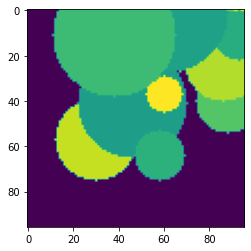

In [80]:
plt.imshow(train_ds[0][0][0].cpu())

Training for run 0
----------
epoch 1/10
1/22, train_loss: 0.4329
2/22, train_loss: 0.3457
3/22, train_loss: 0.3983
4/22, train_loss: 0.3225
5/22, train_loss: 0.2966
6/22, train_loss: 0.3816
7/22, train_loss: 0.3187
8/22, train_loss: 0.3920
9/22, train_loss: 0.3385
10/22, train_loss: 0.3143
11/22, train_loss: 0.3145
12/22, train_loss: 0.2883
13/22, train_loss: 0.3470
14/22, train_loss: 0.2770
15/22, train_loss: 0.3590
16/22, train_loss: 0.2933
17/22, train_loss: 0.3877
18/22, train_loss: 0.2901
19/22, train_loss: 0.2972
20/22, train_loss: 0.3160
21/22, train_loss: 0.2527
22/22, train_loss: 0.2992
23/22, train_loss: 0.3805
epoch 1 average loss: 0.3323
----------
epoch 2/10
1/22, train_loss: 0.2615
2/22, train_loss: 0.2776
3/22, train_loss: 0.2596
4/22, train_loss: 0.2915
5/22, train_loss: 0.2687
6/22, train_loss: 0.2925
7/22, train_loss: 0.2305
8/22, train_loss: 0.3643
9/22, train_loss: 0.3320
10/22, train_loss: 0.3037
11/22, train_loss: 0.2475
12/22, train_loss: 0.2854
13/22, train_los

saved new best metric model
current epoch: 12 current mean dice: 0.9849 best mean dice: 0.9849 at epoch 12
----------
epoch 13/10
1/22, train_loss: 0.1459
2/22, train_loss: 0.1240
3/22, train_loss: 0.1554
4/22, train_loss: 0.0784
5/22, train_loss: 0.1664
6/22, train_loss: 0.1059
7/22, train_loss: 0.0813
8/22, train_loss: 0.0842
9/22, train_loss: 0.0746
10/22, train_loss: 0.0767
11/22, train_loss: 0.1482
12/22, train_loss: 0.1024
13/22, train_loss: 0.1056
14/22, train_loss: 0.0989
15/22, train_loss: 0.1285
16/22, train_loss: 0.1051
17/22, train_loss: 0.1727
18/22, train_loss: 0.0881
19/22, train_loss: 0.1095
20/22, train_loss: 0.1135
21/22, train_loss: 0.1153
22/22, train_loss: 0.0791
23/22, train_loss: 0.1712
epoch 13 average loss: 0.1144
----------
epoch 14/10
1/22, train_loss: 0.0927
2/22, train_loss: 0.0952
3/22, train_loss: 0.1145
4/22, train_loss: 0.0822
5/22, train_loss: 0.1440
6/22, train_loss: 0.1139
7/22, train_loss: 0.0852
8/22, train_loss: 0.1346
9/22, train_loss: 0.1173
10/

saved new best metric model
current epoch: 24 current mean dice: 0.9976 best mean dice: 0.9977 at epoch 22
----------
epoch 25/10
1/22, train_loss: 0.0255
2/22, train_loss: 0.0331
3/22, train_loss: 0.0379
4/22, train_loss: 0.0478
5/22, train_loss: 0.0705
6/22, train_loss: 0.0305
7/22, train_loss: 0.0323
8/22, train_loss: 0.0222
9/22, train_loss: 0.0595
10/22, train_loss: 0.0300
11/22, train_loss: 0.0215
12/22, train_loss: 0.0344
13/22, train_loss: 0.1034
14/22, train_loss: 0.0273
15/22, train_loss: 0.0311
16/22, train_loss: 0.0584
17/22, train_loss: 0.0446
18/22, train_loss: 0.0427
19/22, train_loss: 0.0285
20/22, train_loss: 0.0394
21/22, train_loss: 0.0400
22/22, train_loss: 0.0834
23/22, train_loss: 0.0358
epoch 25 average loss: 0.0426
----------
epoch 26/10
1/22, train_loss: 0.0420
2/22, train_loss: 0.0650
3/22, train_loss: 0.0585
4/22, train_loss: 0.0242
5/22, train_loss: 0.0464
6/22, train_loss: 0.0354
7/22, train_loss: 0.0267
8/22, train_loss: 0.0288
9/22, train_loss: 0.0293
10/

saved new best metric model
current epoch: 36 current mean dice: 0.9995 best mean dice: 0.9995 at epoch 36
----------
epoch 37/10
1/22, train_loss: 0.0169
2/22, train_loss: 0.0280
3/22, train_loss: 0.0546
4/22, train_loss: 0.0312
5/22, train_loss: 0.0273
6/22, train_loss: 0.0171
7/22, train_loss: 0.0171
8/22, train_loss: 0.0152
9/22, train_loss: 0.0187
10/22, train_loss: 0.0368
11/22, train_loss: 0.0249
12/22, train_loss: 0.0160
13/22, train_loss: 0.0177
14/22, train_loss: 0.0180
15/22, train_loss: 0.0117
16/22, train_loss: 0.0171
17/22, train_loss: 0.0159
18/22, train_loss: 0.0103
19/22, train_loss: 0.0134
20/22, train_loss: 0.0152
21/22, train_loss: 0.0177
22/22, train_loss: 0.0486
23/22, train_loss: 0.0118
epoch 37 average loss: 0.0218
----------
epoch 38/10
1/22, train_loss: 0.0168
2/22, train_loss: 0.0144
3/22, train_loss: 0.0189
4/22, train_loss: 0.0160
5/22, train_loss: 0.0282
6/22, train_loss: 0.0353
7/22, train_loss: 0.0481
8/22, train_loss: 0.0150
9/22, train_loss: 0.0185
10/

saved new best metric model
current epoch: 48 current mean dice: 0.9998 best mean dice: 0.9998 at epoch 48
----------
epoch 49/10
1/22, train_loss: 0.0591
2/22, train_loss: 0.0076
3/22, train_loss: 0.0078
4/22, train_loss: 0.0194
5/22, train_loss: 0.0191
6/22, train_loss: 0.0077
7/22, train_loss: 0.0106
8/22, train_loss: 0.0147
9/22, train_loss: 0.0219
10/22, train_loss: 0.0088
11/22, train_loss: 0.0227
12/22, train_loss: 0.0100
13/22, train_loss: 0.0357
14/22, train_loss: 0.0091
15/22, train_loss: 0.0062
16/22, train_loss: 0.0084
17/22, train_loss: 0.0089
18/22, train_loss: 0.0266
19/22, train_loss: 0.0206
20/22, train_loss: 0.0067
21/22, train_loss: 0.0075
22/22, train_loss: 0.0090
23/22, train_loss: 0.0069
epoch 49 average loss: 0.0154
----------
epoch 50/10
1/22, train_loss: 0.0165
2/22, train_loss: 0.0174
3/22, train_loss: 0.0230
4/22, train_loss: 0.0106
5/22, train_loss: 0.0144
6/22, train_loss: 0.0087
7/22, train_loss: 0.0176
8/22, train_loss: 0.0141
9/22, train_loss: 0.0327
10/

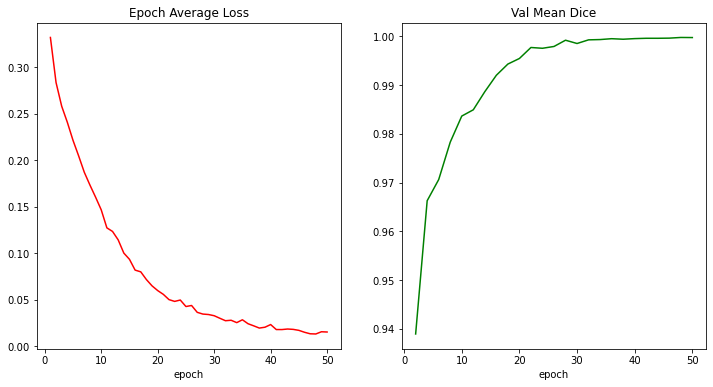

Dice in Test partition for run 00.999882698059082
Training for run 1
----------
epoch 1/10
1/22, train_loss: 0.4851
2/22, train_loss: 0.4052
3/22, train_loss: 0.4781
4/22, train_loss: 0.5089
5/22, train_loss: 0.4569
6/22, train_loss: 0.4556
7/22, train_loss: 0.4402
8/22, train_loss: 0.4643
9/22, train_loss: 0.4486
10/22, train_loss: 0.4883
11/22, train_loss: 0.4049
12/22, train_loss: 0.4285
13/22, train_loss: 0.4347
14/22, train_loss: 0.5000
15/22, train_loss: 0.4998
16/22, train_loss: 0.4767
17/22, train_loss: 0.5229
18/22, train_loss: 0.4838
19/22, train_loss: 0.4594
20/22, train_loss: 0.4664
21/22, train_loss: 0.4917
22/22, train_loss: 0.4515
23/22, train_loss: 0.5111
epoch 1 average loss: 0.4679
----------
epoch 2/10
1/22, train_loss: 0.4792
2/22, train_loss: 0.4288
3/22, train_loss: 0.4634
4/22, train_loss: 0.4696
5/22, train_loss: 0.4147
6/22, train_loss: 0.3900
7/22, train_loss: 0.4281
8/22, train_loss: 0.4013
9/22, train_loss: 0.4263
10/22, train_loss: 0.4603
11/22, train_loss:

saved new best metric model
current epoch: 12 current mean dice: 0.9853 best mean dice: 0.9859 at epoch 10
----------
epoch 13/10
1/22, train_loss: 0.1443
2/22, train_loss: 0.1991
3/22, train_loss: 0.1427
4/22, train_loss: 0.1285
5/22, train_loss: 0.1506
6/22, train_loss: 0.1588
7/22, train_loss: 0.1318
8/22, train_loss: 0.1266
9/22, train_loss: 0.2304
10/22, train_loss: 0.1621
11/22, train_loss: 0.1418
12/22, train_loss: 0.1135
13/22, train_loss: 0.2255
14/22, train_loss: 0.1462
15/22, train_loss: 0.1326
16/22, train_loss: 0.1705
17/22, train_loss: 0.1423
18/22, train_loss: 0.1609
19/22, train_loss: 0.1725
20/22, train_loss: 0.1074
21/22, train_loss: 0.1280
22/22, train_loss: 0.1054
23/22, train_loss: 0.1400
epoch 13 average loss: 0.1505
----------
epoch 14/10
1/22, train_loss: 0.1123
2/22, train_loss: 0.1199
3/22, train_loss: 0.1406
4/22, train_loss: 0.1689
5/22, train_loss: 0.1262
6/22, train_loss: 0.1388
7/22, train_loss: 0.1665
8/22, train_loss: 0.1543
9/22, train_loss: 0.1132
10/

saved new best metric model
current epoch: 24 current mean dice: 0.9974 best mean dice: 0.9974 at epoch 24
----------
epoch 25/10
1/22, train_loss: 0.0580
2/22, train_loss: 0.0489
3/22, train_loss: 0.0651
4/22, train_loss: 0.0415
5/22, train_loss: 0.0420
6/22, train_loss: 0.1005
7/22, train_loss: 0.0727
8/22, train_loss: 0.0604
9/22, train_loss: 0.0374
10/22, train_loss: 0.0527
11/22, train_loss: 0.0709
12/22, train_loss: 0.0488
13/22, train_loss: 0.0697
14/22, train_loss: 0.0386
15/22, train_loss: 0.0466
16/22, train_loss: 0.0353
17/22, train_loss: 0.0655
18/22, train_loss: 0.0370
19/22, train_loss: 0.0534
20/22, train_loss: 0.0441
21/22, train_loss: 0.0575
22/22, train_loss: 0.0604
23/22, train_loss: 0.0952
epoch 25 average loss: 0.0566
----------
epoch 26/10
1/22, train_loss: 0.0368
2/22, train_loss: 0.0542
3/22, train_loss: 0.0733
4/22, train_loss: 0.0442
5/22, train_loss: 0.0673
6/22, train_loss: 0.0411
7/22, train_loss: 0.0618
8/22, train_loss: 0.0536
9/22, train_loss: 0.0757
10/

20/22, train_loss: 0.0316
21/22, train_loss: 0.0555
22/22, train_loss: 0.0932
23/22, train_loss: 0.0162
epoch 36 average loss: 0.0331
saved new best metric model
current epoch: 36 current mean dice: 0.9988 best mean dice: 0.9993 at epoch 34
----------
epoch 37/10
1/22, train_loss: 0.0168
2/22, train_loss: 0.0195
3/22, train_loss: 0.0287
4/22, train_loss: 0.0228
5/22, train_loss: 0.0482
6/22, train_loss: 0.0258
7/22, train_loss: 0.0230
8/22, train_loss: 0.0343
9/22, train_loss: 0.0257
10/22, train_loss: 0.0295
11/22, train_loss: 0.0219
12/22, train_loss: 0.0232
13/22, train_loss: 0.0189
14/22, train_loss: 0.0178
15/22, train_loss: 0.0166
16/22, train_loss: 0.0499
17/22, train_loss: 0.0775
18/22, train_loss: 0.0375
19/22, train_loss: 0.0533
20/22, train_loss: 0.0252
21/22, train_loss: 0.0264
22/22, train_loss: 0.0271
23/22, train_loss: 0.0251
epoch 37 average loss: 0.0302
----------
epoch 38/10
1/22, train_loss: 0.0165
2/22, train_loss: 0.0231
3/22, train_loss: 0.0234
4/22, train_loss: 0

19/22, train_loss: 0.0165
20/22, train_loss: 0.0106
21/22, train_loss: 0.0193
22/22, train_loss: 0.0150
23/22, train_loss: 0.0080
epoch 48 average loss: 0.0198
saved new best metric model
current epoch: 48 current mean dice: 0.9997 best mean dice: 0.9997 at epoch 48
----------
epoch 49/10
1/22, train_loss: 0.0270
2/22, train_loss: 0.0109
3/22, train_loss: 0.0145
4/22, train_loss: 0.0086
5/22, train_loss: 0.0141
6/22, train_loss: 0.0108
7/22, train_loss: 0.0330
8/22, train_loss: 0.0234
9/22, train_loss: 0.0172
10/22, train_loss: 0.0106
11/22, train_loss: 0.0543
12/22, train_loss: 0.0164
13/22, train_loss: 0.0125
14/22, train_loss: 0.0093
15/22, train_loss: 0.0123
16/22, train_loss: 0.0223
17/22, train_loss: 0.0276
18/22, train_loss: 0.0157
19/22, train_loss: 0.0188
20/22, train_loss: 0.0317
21/22, train_loss: 0.0160
22/22, train_loss: 0.0236
23/22, train_loss: 0.0227
epoch 49 average loss: 0.0197
----------
epoch 50/10
1/22, train_loss: 0.0261
2/22, train_loss: 0.0158
3/22, train_loss: 

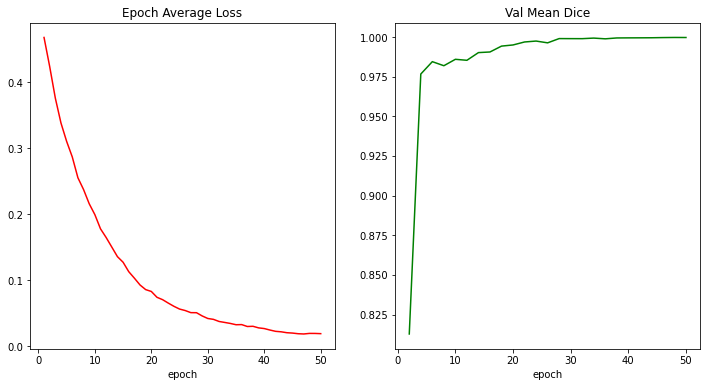

Dice in Test partition for run 10.9998468160629272
Training for run 2
----------
epoch 1/10
1/22, train_loss: 0.3882
2/22, train_loss: 0.4069
3/22, train_loss: 0.3535
4/22, train_loss: 0.2851
5/22, train_loss: 0.3213
6/22, train_loss: 0.2953
7/22, train_loss: 0.2809
8/22, train_loss: 0.2634
9/22, train_loss: 0.3561
10/22, train_loss: 0.2761
11/22, train_loss: 0.2550
12/22, train_loss: 0.3257
13/22, train_loss: 0.2876
14/22, train_loss: 0.2442
15/22, train_loss: 0.3272
16/22, train_loss: 0.2813
17/22, train_loss: 0.3250
18/22, train_loss: 0.2700
19/22, train_loss: 0.2895
20/22, train_loss: 0.2529
21/22, train_loss: 0.2104
22/22, train_loss: 0.2563
23/22, train_loss: 0.3194
epoch 1 average loss: 0.2988
----------
epoch 2/10
1/22, train_loss: 0.2181
2/22, train_loss: 0.2589
3/22, train_loss: 0.2269
4/22, train_loss: 0.2214
5/22, train_loss: 0.2164
6/22, train_loss: 0.2078
7/22, train_loss: 0.2754
8/22, train_loss: 0.2899
9/22, train_loss: 0.2451
10/22, train_loss: 0.2517
11/22, train_loss

saved new best metric model
current epoch: 12 current mean dice: 0.9866 best mean dice: 0.9866 at epoch 12
----------
epoch 13/10
1/22, train_loss: 0.0654
2/22, train_loss: 0.1069
3/22, train_loss: 0.0655
4/22, train_loss: 0.0972
5/22, train_loss: 0.0618
6/22, train_loss: 0.1115
7/22, train_loss: 0.1104
8/22, train_loss: 0.0988
9/22, train_loss: 0.0879
10/22, train_loss: 0.1000
11/22, train_loss: 0.0695
12/22, train_loss: 0.0928
13/22, train_loss: 0.0824
14/22, train_loss: 0.1019
15/22, train_loss: 0.1241
16/22, train_loss: 0.0895
17/22, train_loss: 0.0624
18/22, train_loss: 0.0563
19/22, train_loss: 0.1150
20/22, train_loss: 0.1008
21/22, train_loss: 0.1085
22/22, train_loss: 0.0568
23/22, train_loss: 0.0647
epoch 13 average loss: 0.0883
----------
epoch 14/10
1/22, train_loss: 0.1256
2/22, train_loss: 0.1241
3/22, train_loss: 0.0559
4/22, train_loss: 0.0773
5/22, train_loss: 0.0501
6/22, train_loss: 0.1667
7/22, train_loss: 0.1415
8/22, train_loss: 0.0868
9/22, train_loss: 0.0683
10/

saved new best metric model
current epoch: 24 current mean dice: 0.9986 best mean dice: 0.9986 at epoch 24
----------
epoch 25/10
1/22, train_loss: 0.0184
2/22, train_loss: 0.0504
3/22, train_loss: 0.0403
4/22, train_loss: 0.0651
5/22, train_loss: 0.0332
6/22, train_loss: 0.0342
7/22, train_loss: 0.0191
8/22, train_loss: 0.0452
9/22, train_loss: 0.0332
10/22, train_loss: 0.0210
11/22, train_loss: 0.0202
12/22, train_loss: 0.0847
13/22, train_loss: 0.0260
14/22, train_loss: 0.0294
15/22, train_loss: 0.0494
16/22, train_loss: 0.0252
17/22, train_loss: 0.0206
18/22, train_loss: 0.0164
19/22, train_loss: 0.0193
20/22, train_loss: 0.1082
21/22, train_loss: 0.0287
22/22, train_loss: 0.0361
23/22, train_loss: 0.0463
epoch 25 average loss: 0.0379
----------
epoch 26/10
1/22, train_loss: 0.0246
2/22, train_loss: 0.0170
3/22, train_loss: 0.0291
4/22, train_loss: 0.0396
5/22, train_loss: 0.0177
6/22, train_loss: 0.0436
7/22, train_loss: 0.0430
8/22, train_loss: 0.0250
9/22, train_loss: 0.0278
10/

saved new best metric model
current epoch: 36 current mean dice: 0.9991 best mean dice: 0.9993 at epoch 32
----------
epoch 37/10
1/22, train_loss: 0.0120
2/22, train_loss: 0.0124
3/22, train_loss: 0.0118
4/22, train_loss: 0.0226
5/22, train_loss: 0.0293
6/22, train_loss: 0.0234
7/22, train_loss: 0.0121
8/22, train_loss: 0.0262
9/22, train_loss: 0.0106
10/22, train_loss: 0.0119
11/22, train_loss: 0.0572
12/22, train_loss: 0.0253
13/22, train_loss: 0.0318
14/22, train_loss: 0.0108
15/22, train_loss: 0.0093
16/22, train_loss: 0.0217
17/22, train_loss: 0.0156
18/22, train_loss: 0.0144
19/22, train_loss: 0.0436
20/22, train_loss: 0.0159
21/22, train_loss: 0.0178
22/22, train_loss: 0.0139
23/22, train_loss: 0.0140
epoch 37 average loss: 0.0202
----------
epoch 38/10
1/22, train_loss: 0.0201
2/22, train_loss: 0.0140
3/22, train_loss: 0.0102
4/22, train_loss: 0.0114
5/22, train_loss: 0.0226
6/22, train_loss: 0.0246
7/22, train_loss: 0.0196
8/22, train_loss: 0.0108
9/22, train_loss: 0.0133
10/

saved new best metric model
current epoch: 48 current mean dice: 0.9996 best mean dice: 0.9997 at epoch 40
----------
epoch 49/10
1/22, train_loss: 0.0228
2/22, train_loss: 0.0124
3/22, train_loss: 0.0113
4/22, train_loss: 0.0126
5/22, train_loss: 0.0092
6/22, train_loss: 0.0078
7/22, train_loss: 0.0121
8/22, train_loss: 0.0071
9/22, train_loss: 0.0107
10/22, train_loss: 0.0069
11/22, train_loss: 0.0351
12/22, train_loss: 0.0111
13/22, train_loss: 0.0165
14/22, train_loss: 0.0150
15/22, train_loss: 0.0071
16/22, train_loss: 0.0082
17/22, train_loss: 0.0145
18/22, train_loss: 0.0127
19/22, train_loss: 0.0089
20/22, train_loss: 0.0073
21/22, train_loss: 0.0055
22/22, train_loss: 0.0307
23/22, train_loss: 0.0060
epoch 49 average loss: 0.0127
----------
epoch 50/10
1/22, train_loss: 0.0074
2/22, train_loss: 0.0428
3/22, train_loss: 0.0113
4/22, train_loss: 0.0055
5/22, train_loss: 0.0122
6/22, train_loss: 0.0088
7/22, train_loss: 0.0081
8/22, train_loss: 0.0096
9/22, train_loss: 0.0327
10/

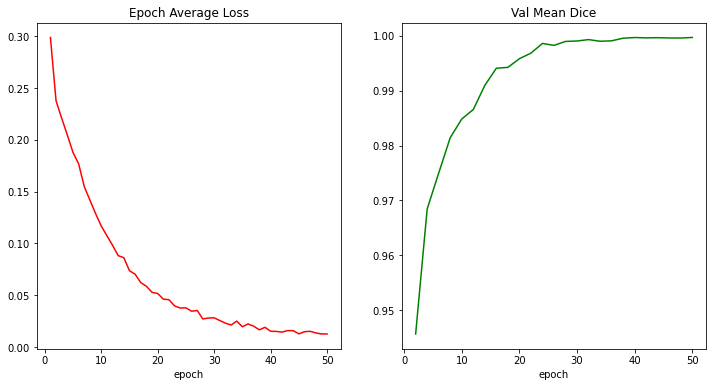

Dice in Test partition for run 20.9998568296432495
Training for run 3
----------
epoch 1/10
1/22, train_loss: 0.4065
2/22, train_loss: 0.4338
3/22, train_loss: 0.3780
4/22, train_loss: 0.3512
5/22, train_loss: 0.3375
6/22, train_loss: 0.3955
7/22, train_loss: 0.3768
8/22, train_loss: 0.4031
9/22, train_loss: 0.3796
10/22, train_loss: 0.3569
11/22, train_loss: 0.3814
12/22, train_loss: 0.3145
13/22, train_loss: 0.3433
14/22, train_loss: 0.3993
15/22, train_loss: 0.3116
16/22, train_loss: 0.3238
17/22, train_loss: 0.3487
18/22, train_loss: 0.3537
19/22, train_loss: 0.3885
20/22, train_loss: 0.3509
21/22, train_loss: 0.3481
22/22, train_loss: 0.3094
23/22, train_loss: 0.2975
epoch 1 average loss: 0.3604
----------
epoch 2/10
1/22, train_loss: 0.3453
2/22, train_loss: 0.3161
3/22, train_loss: 0.3132
4/22, train_loss: 0.3574
5/22, train_loss: 0.3143
6/22, train_loss: 0.2837
7/22, train_loss: 0.3333
8/22, train_loss: 0.3062
9/22, train_loss: 0.3112
10/22, train_loss: 0.3230
11/22, train_loss

saved new best metric model
current epoch: 12 current mean dice: 0.9873 best mean dice: 0.9873 at epoch 12
----------
epoch 13/10
1/22, train_loss: 0.1634
2/22, train_loss: 0.1167
3/22, train_loss: 0.1248
4/22, train_loss: 0.0895
5/22, train_loss: 0.1648
6/22, train_loss: 0.1995
7/22, train_loss: 0.0872
8/22, train_loss: 0.1815
9/22, train_loss: 0.1462
10/22, train_loss: 0.0967
11/22, train_loss: 0.1077
12/22, train_loss: 0.1124
13/22, train_loss: 0.1784
14/22, train_loss: 0.1013
15/22, train_loss: 0.1002
16/22, train_loss: 0.0861
17/22, train_loss: 0.0836
18/22, train_loss: 0.1202
19/22, train_loss: 0.1134
20/22, train_loss: 0.1069
21/22, train_loss: 0.1011
22/22, train_loss: 0.1477
23/22, train_loss: 0.1257
epoch 13 average loss: 0.1241
----------
epoch 14/10
1/22, train_loss: 0.1413
2/22, train_loss: 0.0861
3/22, train_loss: 0.1185
4/22, train_loss: 0.0951
5/22, train_loss: 0.0969
6/22, train_loss: 0.0807
7/22, train_loss: 0.1568
8/22, train_loss: 0.0815
9/22, train_loss: 0.1219
10/

20/22, train_loss: 0.0409
21/22, train_loss: 0.1085
22/22, train_loss: 0.0319
23/22, train_loss: 0.0742
epoch 24 average loss: 0.0512
saved new best metric model
current epoch: 24 current mean dice: 0.9957 best mean dice: 0.9957 at epoch 24
----------
epoch 25/10
1/22, train_loss: 0.0377
2/22, train_loss: 0.0416
3/22, train_loss: 0.0403
4/22, train_loss: 0.0601
5/22, train_loss: 0.0334
6/22, train_loss: 0.0579
7/22, train_loss: 0.0320
8/22, train_loss: 0.0361
9/22, train_loss: 0.0299
10/22, train_loss: 0.0456
11/22, train_loss: 0.0359
12/22, train_loss: 0.0285
13/22, train_loss: 0.0655
14/22, train_loss: 0.0725
15/22, train_loss: 0.0428
16/22, train_loss: 0.0323
17/22, train_loss: 0.0801
18/22, train_loss: 0.0517
19/22, train_loss: 0.0527
20/22, train_loss: 0.0321
21/22, train_loss: 0.0416
22/22, train_loss: 0.0418
23/22, train_loss: 0.0395
epoch 25 average loss: 0.0448
----------
epoch 26/10
1/22, train_loss: 0.0799
2/22, train_loss: 0.0351
3/22, train_loss: 0.0724
4/22, train_loss: 0

20/22, train_loss: 0.0326
21/22, train_loss: 0.0178
22/22, train_loss: 0.0246
23/22, train_loss: 0.0330
epoch 36 average loss: 0.0259
saved new best metric model
current epoch: 36 current mean dice: 0.9993 best mean dice: 0.9993 at epoch 36
----------
epoch 37/10
1/22, train_loss: 0.0222
2/22, train_loss: 0.0160
3/22, train_loss: 0.0363
4/22, train_loss: 0.0282
5/22, train_loss: 0.0256
6/22, train_loss: 0.0213
7/22, train_loss: 0.0233
8/22, train_loss: 0.0241
9/22, train_loss: 0.0294
10/22, train_loss: 0.0437
11/22, train_loss: 0.0346
12/22, train_loss: 0.0189
13/22, train_loss: 0.0208
14/22, train_loss: 0.0131
15/22, train_loss: 0.0379
16/22, train_loss: 0.0310
17/22, train_loss: 0.0181
18/22, train_loss: 0.0422
19/22, train_loss: 0.0190
20/22, train_loss: 0.0269
21/22, train_loss: 0.0222
22/22, train_loss: 0.0210
23/22, train_loss: 0.0129
epoch 37 average loss: 0.0256
----------
epoch 38/10
1/22, train_loss: 0.0219
2/22, train_loss: 0.0213
3/22, train_loss: 0.0306
4/22, train_loss: 0

19/22, train_loss: 0.0194
20/22, train_loss: 0.0183
21/22, train_loss: 0.0106
22/22, train_loss: 0.0105
23/22, train_loss: 0.0204
epoch 48 average loss: 0.0177
saved new best metric model
current epoch: 48 current mean dice: 0.9997 best mean dice: 0.9997 at epoch 46
----------
epoch 49/10
1/22, train_loss: 0.0198
2/22, train_loss: 0.0098
3/22, train_loss: 0.0121
4/22, train_loss: 0.0115
5/22, train_loss: 0.0107
6/22, train_loss: 0.0123
7/22, train_loss: 0.0089
8/22, train_loss: 0.0096
9/22, train_loss: 0.0109
10/22, train_loss: 0.0084
11/22, train_loss: 0.0182
12/22, train_loss: 0.0476
13/22, train_loss: 0.0152
14/22, train_loss: 0.0187
15/22, train_loss: 0.0126
16/22, train_loss: 0.0117
17/22, train_loss: 0.0114
18/22, train_loss: 0.0140
19/22, train_loss: 0.0127
20/22, train_loss: 0.0292
21/22, train_loss: 0.0104
22/22, train_loss: 0.0230
23/22, train_loss: 0.0080
epoch 49 average loss: 0.0151
----------
epoch 50/10
1/22, train_loss: 0.0211
2/22, train_loss: 0.0098
3/22, train_loss: 

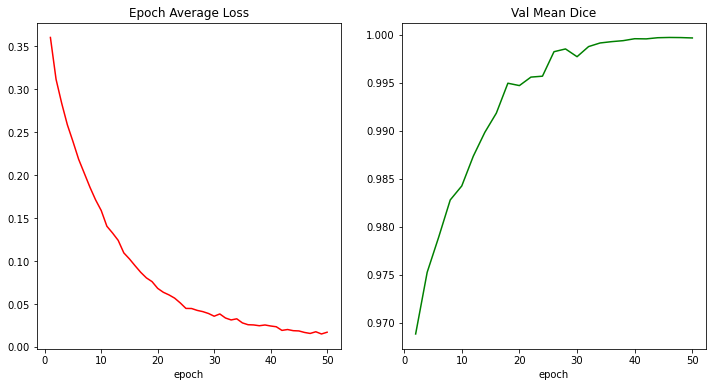

Dice in Test partition for run 30.9998229742050171
Training for run 4
----------
epoch 1/10
1/22, train_loss: 0.5451
2/22, train_loss: 0.4804
3/22, train_loss: 0.4536
4/22, train_loss: 0.4140
5/22, train_loss: 0.4205
6/22, train_loss: 0.3600
7/22, train_loss: 0.3709
8/22, train_loss: 0.4074
9/22, train_loss: 0.3359
10/22, train_loss: 0.3359
11/22, train_loss: 0.3486
12/22, train_loss: 0.3579
13/22, train_loss: 0.2959
14/22, train_loss: 0.3807
15/22, train_loss: 0.3037
16/22, train_loss: 0.3016
17/22, train_loss: 0.3036
18/22, train_loss: 0.3275
19/22, train_loss: 0.2797
20/22, train_loss: 0.3118
21/22, train_loss: 0.2821
22/22, train_loss: 0.2782
23/22, train_loss: 0.2731
epoch 1 average loss: 0.3551
----------
epoch 2/10
1/22, train_loss: 0.2940
2/22, train_loss: 0.2670
3/22, train_loss: 0.2883
4/22, train_loss: 0.2966
5/22, train_loss: 0.3000
6/22, train_loss: 0.2712
7/22, train_loss: 0.2520
8/22, train_loss: 0.2819
9/22, train_loss: 0.2618
10/22, train_loss: 0.2717
11/22, train_loss

saved new best metric model
current epoch: 12 current mean dice: 0.9898 best mean dice: 0.9898 at epoch 12
----------
epoch 13/10
1/22, train_loss: 0.1306
2/22, train_loss: 0.0940
3/22, train_loss: 0.0787
4/22, train_loss: 0.1037
5/22, train_loss: 0.0856
6/22, train_loss: 0.1059
7/22, train_loss: 0.0999
8/22, train_loss: 0.0705
9/22, train_loss: 0.1113
10/22, train_loss: 0.1005
11/22, train_loss: 0.1160
12/22, train_loss: 0.0936
13/22, train_loss: 0.1002
14/22, train_loss: 0.1217
15/22, train_loss: 0.1410
16/22, train_loss: 0.1216
17/22, train_loss: 0.0858
18/22, train_loss: 0.0748
19/22, train_loss: 0.0752
20/22, train_loss: 0.0879
21/22, train_loss: 0.1209
22/22, train_loss: 0.1003
23/22, train_loss: 0.1009
epoch 13 average loss: 0.1009
----------
epoch 14/10
1/22, train_loss: 0.1054
2/22, train_loss: 0.0822
3/22, train_loss: 0.0647
4/22, train_loss: 0.0784
5/22, train_loss: 0.0871
6/22, train_loss: 0.0867
7/22, train_loss: 0.0738
8/22, train_loss: 0.0980
9/22, train_loss: 0.0762
10/

saved new best metric model
current epoch: 24 current mean dice: 0.9971 best mean dice: 0.9971 at epoch 24
----------
epoch 25/10
1/22, train_loss: 0.0513
2/22, train_loss: 0.0622
3/22, train_loss: 0.0448
4/22, train_loss: 0.0244
5/22, train_loss: 0.0328
6/22, train_loss: 0.0305
7/22, train_loss: 0.0243
8/22, train_loss: 0.0642
9/22, train_loss: 0.0379
10/22, train_loss: 0.0645
11/22, train_loss: 0.0562
12/22, train_loss: 0.0298
13/22, train_loss: 0.0579
14/22, train_loss: 0.0426
15/22, train_loss: 0.0508
16/22, train_loss: 0.0380
17/22, train_loss: 0.0355
18/22, train_loss: 0.0461
19/22, train_loss: 0.0363
20/22, train_loss: 0.0331
21/22, train_loss: 0.0279
22/22, train_loss: 0.0241
23/22, train_loss: 0.0245
epoch 25 average loss: 0.0409
----------
epoch 26/10
1/22, train_loss: 0.0261
2/22, train_loss: 0.0358
3/22, train_loss: 0.0519
4/22, train_loss: 0.0573
5/22, train_loss: 0.0238
6/22, train_loss: 0.0369
7/22, train_loss: 0.0412
8/22, train_loss: 0.0286
9/22, train_loss: 0.0358
10/

20/22, train_loss: 0.0187
21/22, train_loss: 0.0162
22/22, train_loss: 0.0242
23/22, train_loss: 0.0187
epoch 36 average loss: 0.0236
saved new best metric model
current epoch: 36 current mean dice: 0.9991 best mean dice: 0.9992 at epoch 34
----------
epoch 37/10
1/22, train_loss: 0.0144
2/22, train_loss: 0.0194
3/22, train_loss: 0.0205
4/22, train_loss: 0.0330
5/22, train_loss: 0.0187
6/22, train_loss: 0.0262
7/22, train_loss: 0.0178
8/22, train_loss: 0.0271
9/22, train_loss: 0.0280
10/22, train_loss: 0.0340
11/22, train_loss: 0.0204
12/22, train_loss: 0.0171
13/22, train_loss: 0.0212
14/22, train_loss: 0.0219
15/22, train_loss: 0.0182
16/22, train_loss: 0.0142
17/22, train_loss: 0.0237
18/22, train_loss: 0.0171
19/22, train_loss: 0.0126
20/22, train_loss: 0.0344
21/22, train_loss: 0.0319
22/22, train_loss: 0.0155
23/22, train_loss: 0.0107
epoch 37 average loss: 0.0217
----------
epoch 38/10
1/22, train_loss: 0.0233
2/22, train_loss: 0.0192
3/22, train_loss: 0.0258
4/22, train_loss: 0

20/22, train_loss: 0.0146
21/22, train_loss: 0.0134
22/22, train_loss: 0.0226
23/22, train_loss: 0.0088
epoch 48 average loss: 0.0149
saved new best metric model
current epoch: 48 current mean dice: 0.9995 best mean dice: 0.9995 at epoch 48
----------
epoch 49/10
1/22, train_loss: 0.0073
2/22, train_loss: 0.0167
3/22, train_loss: 0.0092
4/22, train_loss: 0.0151
5/22, train_loss: 0.0135
6/22, train_loss: 0.0129
7/22, train_loss: 0.0257
8/22, train_loss: 0.0091
9/22, train_loss: 0.0165
10/22, train_loss: 0.0096
11/22, train_loss: 0.0289
12/22, train_loss: 0.0142
13/22, train_loss: 0.0317
14/22, train_loss: 0.0126
15/22, train_loss: 0.0115
16/22, train_loss: 0.0389
17/22, train_loss: 0.0124
18/22, train_loss: 0.0096
19/22, train_loss: 0.0056
20/22, train_loss: 0.0114
21/22, train_loss: 0.0196
22/22, train_loss: 0.0274
23/22, train_loss: 0.0099
epoch 49 average loss: 0.0161
----------
epoch 50/10
1/22, train_loss: 0.0095
2/22, train_loss: 0.0113
3/22, train_loss: 0.0113
4/22, train_loss: 0

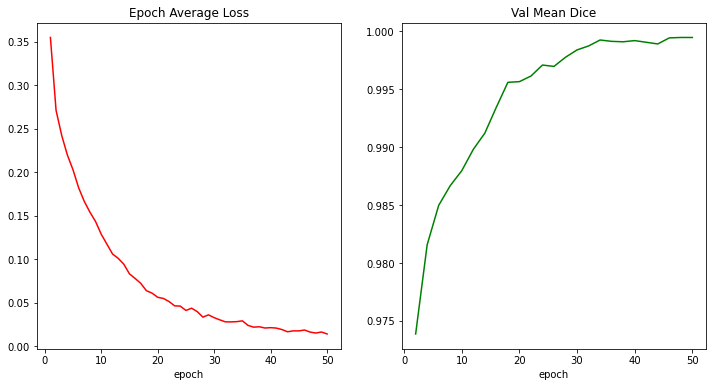

Dice in Test partition for run 40.9997369050979614
Training for run 5
----------
epoch 1/10
1/22, train_loss: 0.4166
2/22, train_loss: 0.2902
3/22, train_loss: 0.3387
4/22, train_loss: 0.3108
5/22, train_loss: 0.3431
6/22, train_loss: 0.3263
7/22, train_loss: 0.2599
8/22, train_loss: 0.2313
9/22, train_loss: 0.2921
10/22, train_loss: 0.2110
11/22, train_loss: 0.2677
12/22, train_loss: 0.2963
13/22, train_loss: 0.2636
14/22, train_loss: 0.3351
15/22, train_loss: 0.2064
16/22, train_loss: 0.2671
17/22, train_loss: 0.2084
18/22, train_loss: 0.2144
19/22, train_loss: 0.2317
20/22, train_loss: 0.2506
21/22, train_loss: 0.2418
22/22, train_loss: 0.2334
23/22, train_loss: 0.2719
epoch 1 average loss: 0.2743
----------
epoch 2/10
1/22, train_loss: 0.2738
2/22, train_loss: 0.2757
3/22, train_loss: 0.2124
4/22, train_loss: 0.1999
5/22, train_loss: 0.2903
6/22, train_loss: 0.2237
7/22, train_loss: 0.1856
8/22, train_loss: 0.2093
9/22, train_loss: 0.2664
10/22, train_loss: 0.2323
11/22, train_loss

saved new best metric model
current epoch: 12 current mean dice: 0.9846 best mean dice: 0.9846 at epoch 12
----------
epoch 13/10
1/22, train_loss: 0.0581
2/22, train_loss: 0.0660
3/22, train_loss: 0.0867
4/22, train_loss: 0.0744
5/22, train_loss: 0.0543
6/22, train_loss: 0.0780
7/22, train_loss: 0.0782
8/22, train_loss: 0.1336
9/22, train_loss: 0.1050
10/22, train_loss: 0.0730
11/22, train_loss: 0.0802
12/22, train_loss: 0.1281
13/22, train_loss: 0.0668
14/22, train_loss: 0.0679
15/22, train_loss: 0.0914
16/22, train_loss: 0.0670
17/22, train_loss: 0.0920
18/22, train_loss: 0.1118
19/22, train_loss: 0.1462
20/22, train_loss: 0.0988
21/22, train_loss: 0.0856
22/22, train_loss: 0.0742
23/22, train_loss: 0.2166
epoch 13 average loss: 0.0928
----------
epoch 14/10
1/22, train_loss: 0.1173
2/22, train_loss: 0.0626
3/22, train_loss: 0.0957
4/22, train_loss: 0.0813
5/22, train_loss: 0.0679
6/22, train_loss: 0.0707
7/22, train_loss: 0.0750
8/22, train_loss: 0.0556
9/22, train_loss: 0.0530
10/

20/22, train_loss: 0.0258
21/22, train_loss: 0.0363
22/22, train_loss: 0.0239
23/22, train_loss: 0.0165
epoch 24 average loss: 0.0375
saved new best metric model
current epoch: 24 current mean dice: 0.9957 best mean dice: 0.9957 at epoch 24
----------
epoch 25/10
1/22, train_loss: 0.0426
2/22, train_loss: 0.0187
3/22, train_loss: 0.0306
4/22, train_loss: 0.0484
5/22, train_loss: 0.0224
6/22, train_loss: 0.0208
7/22, train_loss: 0.0390
8/22, train_loss: 0.0231
9/22, train_loss: 0.0310
10/22, train_loss: 0.0328
11/22, train_loss: 0.0768
12/22, train_loss: 0.0371
13/22, train_loss: 0.0276
14/22, train_loss: 0.0339
15/22, train_loss: 0.0261
16/22, train_loss: 0.0389
17/22, train_loss: 0.0297
18/22, train_loss: 0.0213
19/22, train_loss: 0.0947
20/22, train_loss: 0.0237
21/22, train_loss: 0.0403
22/22, train_loss: 0.0284
23/22, train_loss: 0.0208
epoch 25 average loss: 0.0352
----------
epoch 26/10
1/22, train_loss: 0.0316
2/22, train_loss: 0.0343
3/22, train_loss: 0.0275
4/22, train_loss: 0

20/22, train_loss: 0.0139
21/22, train_loss: 0.0198
22/22, train_loss: 0.0575
23/22, train_loss: 0.0138
epoch 36 average loss: 0.0216
saved new best metric model
current epoch: 36 current mean dice: 0.9983 best mean dice: 0.9984 at epoch 32
----------
epoch 37/10
1/22, train_loss: 0.0171
2/22, train_loss: 0.0141
3/22, train_loss: 0.0138
4/22, train_loss: 0.0150
5/22, train_loss: 0.0176
6/22, train_loss: 0.0164
7/22, train_loss: 0.0160
8/22, train_loss: 0.0213
9/22, train_loss: 0.0254
10/22, train_loss: 0.0153
11/22, train_loss: 0.0124
12/22, train_loss: 0.0325
13/22, train_loss: 0.0112
14/22, train_loss: 0.0112
15/22, train_loss: 0.0113
16/22, train_loss: 0.0213
17/22, train_loss: 0.0161
18/22, train_loss: 0.0194
19/22, train_loss: 0.0374
20/22, train_loss: 0.0084
21/22, train_loss: 0.0183
22/22, train_loss: 0.0333
23/22, train_loss: 0.0208
epoch 37 average loss: 0.0185
----------
epoch 38/10
1/22, train_loss: 0.0289
2/22, train_loss: 0.0136
3/22, train_loss: 0.0150
4/22, train_loss: 0

19/22, train_loss: 0.0145
20/22, train_loss: 0.0121
21/22, train_loss: 0.0077
22/22, train_loss: 0.0195
23/22, train_loss: 0.0100
epoch 48 average loss: 0.0137
saved new best metric model
current epoch: 48 current mean dice: 0.9994 best mean dice: 0.9994 at epoch 48
----------
epoch 49/10
1/22, train_loss: 0.0097
2/22, train_loss: 0.0090
3/22, train_loss: 0.0202
4/22, train_loss: 0.0066
5/22, train_loss: 0.0099
6/22, train_loss: 0.0123
7/22, train_loss: 0.0188
8/22, train_loss: 0.0124
9/22, train_loss: 0.0053
10/22, train_loss: 0.0281
11/22, train_loss: 0.0113
12/22, train_loss: 0.0080
13/22, train_loss: 0.0124
14/22, train_loss: 0.0104
15/22, train_loss: 0.0063
16/22, train_loss: 0.0111
17/22, train_loss: 0.0177
18/22, train_loss: 0.0099
19/22, train_loss: 0.0061
20/22, train_loss: 0.0103
21/22, train_loss: 0.0097
22/22, train_loss: 0.0091
23/22, train_loss: 0.0313
epoch 49 average loss: 0.0124
----------
epoch 50/10
1/22, train_loss: 0.0070
2/22, train_loss: 0.0146
3/22, train_loss: 

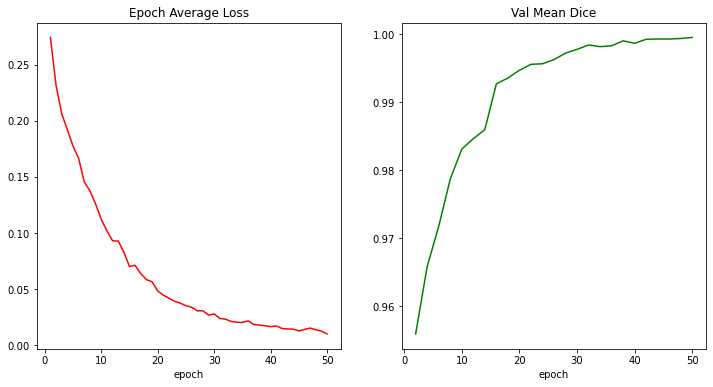

Dice in Test partition for run 50.999785304069519
Training for run 6
----------
epoch 1/10
1/22, train_loss: 0.4057
2/22, train_loss: 0.4085
3/22, train_loss: 0.5185
4/22, train_loss: 0.3419
5/22, train_loss: 0.3952
6/22, train_loss: 0.3278
7/22, train_loss: 0.3274
8/22, train_loss: 0.3616
9/22, train_loss: 0.3678
10/22, train_loss: 0.3372
11/22, train_loss: 0.3442
12/22, train_loss: 0.3712
13/22, train_loss: 0.3029
14/22, train_loss: 0.4345
15/22, train_loss: 0.3399
16/22, train_loss: 0.3094
17/22, train_loss: 0.2935
18/22, train_loss: 0.3502
19/22, train_loss: 0.2998
20/22, train_loss: 0.3308
21/22, train_loss: 0.3587
22/22, train_loss: 0.2985
23/22, train_loss: 0.2838
epoch 1 average loss: 0.3526
----------
epoch 2/10
1/22, train_loss: 0.2898
2/22, train_loss: 0.2780
3/22, train_loss: 0.2658
4/22, train_loss: 0.3465
5/22, train_loss: 0.3328
6/22, train_loss: 0.2665
7/22, train_loss: 0.2902
8/22, train_loss: 0.3219
9/22, train_loss: 0.3443
10/22, train_loss: 0.2749
11/22, train_loss:

saved new best metric model
current epoch: 12 current mean dice: 0.9904 best mean dice: 0.9904 at epoch 12
----------
epoch 13/10
1/22, train_loss: 0.1238
2/22, train_loss: 0.1808
3/22, train_loss: 0.1101
4/22, train_loss: 0.1301
5/22, train_loss: 0.1257
6/22, train_loss: 0.1238
7/22, train_loss: 0.1202
8/22, train_loss: 0.1305
9/22, train_loss: 0.0815
10/22, train_loss: 0.0963
11/22, train_loss: 0.1904
12/22, train_loss: 0.0946
13/22, train_loss: 0.0977
14/22, train_loss: 0.1086
15/22, train_loss: 0.1631
16/22, train_loss: 0.1153
17/22, train_loss: 0.0762
18/22, train_loss: 0.0921
19/22, train_loss: 0.0957
20/22, train_loss: 0.0904
21/22, train_loss: 0.0919
22/22, train_loss: 0.1002
23/22, train_loss: 0.0819
epoch 13 average loss: 0.1139
----------
epoch 14/10
1/22, train_loss: 0.1386
2/22, train_loss: 0.0806
3/22, train_loss: 0.0793
4/22, train_loss: 0.1230
5/22, train_loss: 0.0838
6/22, train_loss: 0.0767
7/22, train_loss: 0.1004
8/22, train_loss: 0.1480
9/22, train_loss: 0.0747
10/

saved new best metric model
current epoch: 24 current mean dice: 0.9975 best mean dice: 0.9975 at epoch 24
----------
epoch 25/10
1/22, train_loss: 0.0404
2/22, train_loss: 0.0472
3/22, train_loss: 0.0289
4/22, train_loss: 0.0640
5/22, train_loss: 0.0442
6/22, train_loss: 0.0301
7/22, train_loss: 0.0475
8/22, train_loss: 0.0350
9/22, train_loss: 0.0509
10/22, train_loss: 0.0617
11/22, train_loss: 0.0856
12/22, train_loss: 0.0367
13/22, train_loss: 0.0465
14/22, train_loss: 0.0300
15/22, train_loss: 0.0398
16/22, train_loss: 0.0302
17/22, train_loss: 0.0384
18/22, train_loss: 0.0355
19/22, train_loss: 0.0282
20/22, train_loss: 0.0524
21/22, train_loss: 0.0327
22/22, train_loss: 0.0256
23/22, train_loss: 0.0609
epoch 25 average loss: 0.0431
----------
epoch 26/10
1/22, train_loss: 0.0983
2/22, train_loss: 0.0360
3/22, train_loss: 0.0428
4/22, train_loss: 0.0313
5/22, train_loss: 0.0376
6/22, train_loss: 0.0395
7/22, train_loss: 0.0484
8/22, train_loss: 0.0493
9/22, train_loss: 0.0309
10/

20/22, train_loss: 0.0274
21/22, train_loss: 0.0295
22/22, train_loss: 0.0145
23/22, train_loss: 0.0714
epoch 36 average loss: 0.0278
saved new best metric model
current epoch: 36 current mean dice: 0.9992 best mean dice: 0.9993 at epoch 32
----------
epoch 37/10
1/22, train_loss: 0.0206
2/22, train_loss: 0.0331
3/22, train_loss: 0.0178
4/22, train_loss: 0.0224
5/22, train_loss: 0.0294
6/22, train_loss: 0.0153
7/22, train_loss: 0.0189
8/22, train_loss: 0.0137
9/22, train_loss: 0.0141
10/22, train_loss: 0.0183
11/22, train_loss: 0.0222
12/22, train_loss: 0.0212
13/22, train_loss: 0.0165
14/22, train_loss: 0.0248
15/22, train_loss: 0.0204
16/22, train_loss: 0.0177
17/22, train_loss: 0.0168
18/22, train_loss: 0.0980
19/22, train_loss: 0.0224
20/22, train_loss: 0.0223
21/22, train_loss: 0.0505
22/22, train_loss: 0.0322
23/22, train_loss: 0.0126
epoch 37 average loss: 0.0253
----------
epoch 38/10
1/22, train_loss: 0.0123
2/22, train_loss: 0.0334
3/22, train_loss: 0.0168
4/22, train_loss: 0

19/22, train_loss: 0.0091
20/22, train_loss: 0.0145
21/22, train_loss: 0.0412
22/22, train_loss: 0.0201
23/22, train_loss: 0.0100
epoch 48 average loss: 0.0168
saved new best metric model
current epoch: 48 current mean dice: 0.9997 best mean dice: 0.9997 at epoch 48
----------
epoch 49/10
1/22, train_loss: 0.0204
2/22, train_loss: 0.0074
3/22, train_loss: 0.0113
4/22, train_loss: 0.0155
5/22, train_loss: 0.0199
6/22, train_loss: 0.0117
7/22, train_loss: 0.0110
8/22, train_loss: 0.0254
9/22, train_loss: 0.0100
10/22, train_loss: 0.0330
11/22, train_loss: 0.0186
12/22, train_loss: 0.0218
13/22, train_loss: 0.0130
14/22, train_loss: 0.0100
15/22, train_loss: 0.0079
16/22, train_loss: 0.0153
17/22, train_loss: 0.0079
18/22, train_loss: 0.0092
19/22, train_loss: 0.0229
20/22, train_loss: 0.0132
21/22, train_loss: 0.0066
22/22, train_loss: 0.0117
23/22, train_loss: 0.0092
epoch 49 average loss: 0.0145
----------
epoch 50/10
1/22, train_loss: 0.0115
2/22, train_loss: 0.0705
3/22, train_loss: 

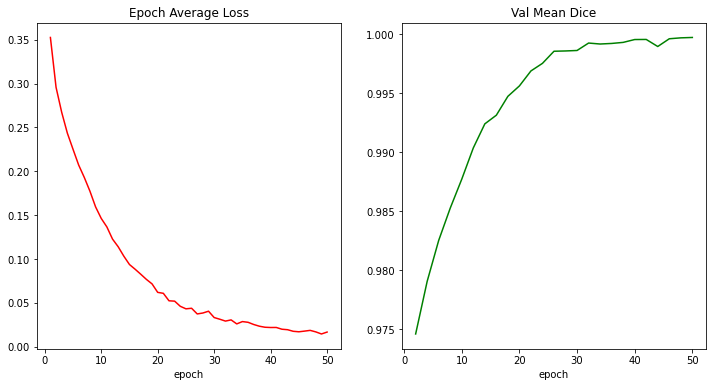

Dice in Test partition for run 60.9998327493667603
Training for run 7
----------
epoch 1/10
1/22, train_loss: 0.4652
2/22, train_loss: 0.4410
3/22, train_loss: 0.4349
4/22, train_loss: 0.4049
5/22, train_loss: 0.3992
6/22, train_loss: 0.3606
7/22, train_loss: 0.3762
8/22, train_loss: 0.3475
9/22, train_loss: 0.4042
10/22, train_loss: 0.3219
11/22, train_loss: 0.3408
12/22, train_loss: 0.3562
13/22, train_loss: 0.3125
14/22, train_loss: 0.3837
15/22, train_loss: 0.3167
16/22, train_loss: 0.3541
17/22, train_loss: 0.3416
18/22, train_loss: 0.3495
19/22, train_loss: 0.3215
20/22, train_loss: 0.3531
21/22, train_loss: 0.3066
22/22, train_loss: 0.2983
23/22, train_loss: 0.3425
epoch 1 average loss: 0.3623
----------
epoch 2/10
1/22, train_loss: 0.2964
2/22, train_loss: 0.3037
3/22, train_loss: 0.3541
4/22, train_loss: 0.3649
5/22, train_loss: 0.3015
6/22, train_loss: 0.3087
7/22, train_loss: 0.2814
8/22, train_loss: 0.2964
9/22, train_loss: 0.3066
10/22, train_loss: 0.2941
11/22, train_loss

saved new best metric model
current epoch: 12 current mean dice: 0.9894 best mean dice: 0.9894 at epoch 12
----------
epoch 13/10
1/22, train_loss: 0.1280
2/22, train_loss: 0.0907
3/22, train_loss: 0.1248
4/22, train_loss: 0.0997
5/22, train_loss: 0.1053
6/22, train_loss: 0.1328
7/22, train_loss: 0.1096
8/22, train_loss: 0.0926
9/22, train_loss: 0.1232
10/22, train_loss: 0.1066
11/22, train_loss: 0.1433
12/22, train_loss: 0.0981
13/22, train_loss: 0.1025
14/22, train_loss: 0.1132
15/22, train_loss: 0.1388
16/22, train_loss: 0.0825
17/22, train_loss: 0.1429
18/22, train_loss: 0.1027
19/22, train_loss: 0.0956
20/22, train_loss: 0.1434
21/22, train_loss: 0.0887
22/22, train_loss: 0.1509
23/22, train_loss: 0.1792
epoch 13 average loss: 0.1172
----------
epoch 14/10
1/22, train_loss: 0.1100
2/22, train_loss: 0.1382
3/22, train_loss: 0.0975
4/22, train_loss: 0.1107
5/22, train_loss: 0.0797
6/22, train_loss: 0.2037
7/22, train_loss: 0.0961
8/22, train_loss: 0.1309
9/22, train_loss: 0.1062
10/

20/22, train_loss: 0.0391
21/22, train_loss: 0.0373
22/22, train_loss: 0.0377
23/22, train_loss: 0.0360
epoch 24 average loss: 0.0503
saved new best metric model
current epoch: 24 current mean dice: 0.9981 best mean dice: 0.9981 at epoch 24
----------
epoch 25/10
1/22, train_loss: 0.0373
2/22, train_loss: 0.0269
3/22, train_loss: 0.0318
4/22, train_loss: 0.0705
5/22, train_loss: 0.0392
6/22, train_loss: 0.0264
7/22, train_loss: 0.0430
8/22, train_loss: 0.0350
9/22, train_loss: 0.0352
10/22, train_loss: 0.0430
11/22, train_loss: 0.0454
12/22, train_loss: 0.0467
13/22, train_loss: 0.0394
14/22, train_loss: 0.0322
15/22, train_loss: 0.0639
16/22, train_loss: 0.0528
17/22, train_loss: 0.0565
18/22, train_loss: 0.0660
19/22, train_loss: 0.0388
20/22, train_loss: 0.0853
21/22, train_loss: 0.0799
22/22, train_loss: 0.0738
23/22, train_loss: 0.0655
epoch 25 average loss: 0.0493
----------
epoch 26/10
1/22, train_loss: 0.0414
2/22, train_loss: 0.0363
3/22, train_loss: 0.0596
4/22, train_loss: 0

19/22, train_loss: 0.0686
20/22, train_loss: 0.0136
21/22, train_loss: 0.0191
22/22, train_loss: 0.0159
23/22, train_loss: 0.0261
epoch 36 average loss: 0.0250
saved new best metric model
current epoch: 36 current mean dice: 0.9991 best mean dice: 0.9992 at epoch 32
----------
epoch 37/10
1/22, train_loss: 0.0286
2/22, train_loss: 0.0211
3/22, train_loss: 0.0227
4/22, train_loss: 0.0282
5/22, train_loss: 0.0374
6/22, train_loss: 0.0160
7/22, train_loss: 0.0451
8/22, train_loss: 0.0261
9/22, train_loss: 0.0157
10/22, train_loss: 0.0442
11/22, train_loss: 0.0232
12/22, train_loss: 0.0139
13/22, train_loss: 0.0167
14/22, train_loss: 0.0154
15/22, train_loss: 0.0179
16/22, train_loss: 0.0445
17/22, train_loss: 0.0255
18/22, train_loss: 0.0164
19/22, train_loss: 0.0268
20/22, train_loss: 0.0328
21/22, train_loss: 0.0205
22/22, train_loss: 0.0163
23/22, train_loss: 0.0210
epoch 37 average loss: 0.0251
----------
epoch 38/10
1/22, train_loss: 0.0230
2/22, train_loss: 0.0123
3/22, train_loss: 

20/22, train_loss: 0.0134
21/22, train_loss: 0.0078
22/22, train_loss: 0.0216
23/22, train_loss: 0.0077
epoch 48 average loss: 0.0159
saved new best metric model
current epoch: 48 current mean dice: 0.9996 best mean dice: 0.9996 at epoch 48
----------
epoch 49/10
1/22, train_loss: 0.0191
2/22, train_loss: 0.0096
3/22, train_loss: 0.0130
4/22, train_loss: 0.0146
5/22, train_loss: 0.0167
6/22, train_loss: 0.0214
7/22, train_loss: 0.0157
8/22, train_loss: 0.0175
9/22, train_loss: 0.0108
10/22, train_loss: 0.0076
11/22, train_loss: 0.0099
12/22, train_loss: 0.0218
13/22, train_loss: 0.0121
14/22, train_loss: 0.0131
15/22, train_loss: 0.0188
16/22, train_loss: 0.0289
17/22, train_loss: 0.0192
18/22, train_loss: 0.0101
19/22, train_loss: 0.0117
20/22, train_loss: 0.0101
21/22, train_loss: 0.0142
22/22, train_loss: 0.0081
23/22, train_loss: 0.0156
epoch 49 average loss: 0.0148
----------
epoch 50/10
1/22, train_loss: 0.0151
2/22, train_loss: 0.0518
3/22, train_loss: 0.0333
4/22, train_loss: 0

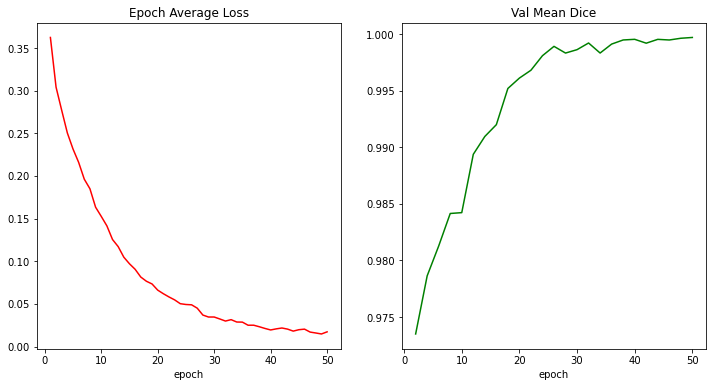

Dice in Test partition for run 70.9998544454574585
Training for run 8
----------
epoch 1/10
1/22, train_loss: 0.5000
2/22, train_loss: 0.3695
3/22, train_loss: 0.3659
4/22, train_loss: 0.3973
5/22, train_loss: 0.3698
6/22, train_loss: 0.2988
7/22, train_loss: 0.3375
8/22, train_loss: 0.3048
9/22, train_loss: 0.2871
10/22, train_loss: 0.3003
11/22, train_loss: 0.2668
12/22, train_loss: 0.2975
13/22, train_loss: 0.3170
14/22, train_loss: 0.2979
15/22, train_loss: 0.2803
16/22, train_loss: 0.2871
17/22, train_loss: 0.2483
18/22, train_loss: 0.3207
19/22, train_loss: 0.2742
20/22, train_loss: 0.2501
21/22, train_loss: 0.2815
22/22, train_loss: 0.2372
23/22, train_loss: 0.2504
epoch 1 average loss: 0.3104
----------
epoch 2/10
1/22, train_loss: 0.2808
2/22, train_loss: 0.2601
3/22, train_loss: 0.2780
4/22, train_loss: 0.2539
5/22, train_loss: 0.2414
6/22, train_loss: 0.2315
7/22, train_loss: 0.2254
8/22, train_loss: 0.2639
9/22, train_loss: 0.2350
10/22, train_loss: 0.2482
11/22, train_loss

saved new best metric model
current epoch: 12 current mean dice: 0.9909 best mean dice: 0.9909 at epoch 12
----------
epoch 13/10
1/22, train_loss: 0.1273
2/22, train_loss: 0.0831
3/22, train_loss: 0.0729
4/22, train_loss: 0.0658
5/22, train_loss: 0.1012
6/22, train_loss: 0.1383
7/22, train_loss: 0.1025
8/22, train_loss: 0.1098
9/22, train_loss: 0.1154
10/22, train_loss: 0.0607
11/22, train_loss: 0.0719
12/22, train_loss: 0.0764
13/22, train_loss: 0.1009
14/22, train_loss: 0.0805
15/22, train_loss: 0.0770
16/22, train_loss: 0.1348
17/22, train_loss: 0.0808
18/22, train_loss: 0.0820
19/22, train_loss: 0.0990
20/22, train_loss: 0.0669
21/22, train_loss: 0.0944
22/22, train_loss: 0.0642
23/22, train_loss: 0.1860
epoch 13 average loss: 0.0953
----------
epoch 14/10
1/22, train_loss: 0.0681
2/22, train_loss: 0.0837
3/22, train_loss: 0.0699
4/22, train_loss: 0.0637
5/22, train_loss: 0.0727
6/22, train_loss: 0.1017
7/22, train_loss: 0.0776
8/22, train_loss: 0.0919
9/22, train_loss: 0.0971
10/

saved new best metric model
current epoch: 24 current mean dice: 0.9975 best mean dice: 0.9975 at epoch 24
----------
epoch 25/10
1/22, train_loss: 0.0468
2/22, train_loss: 0.0498
3/22, train_loss: 0.0300
4/22, train_loss: 0.0491
5/22, train_loss: 0.0367
6/22, train_loss: 0.0280
7/22, train_loss: 0.0420
8/22, train_loss: 0.0440
9/22, train_loss: 0.0759
10/22, train_loss: 0.0307
11/22, train_loss: 0.0421
12/22, train_loss: 0.0256
13/22, train_loss: 0.0405
14/22, train_loss: 0.0224
15/22, train_loss: 0.0394
16/22, train_loss: 0.0422
17/22, train_loss: 0.0342
18/22, train_loss: 0.0394
19/22, train_loss: 0.0603
20/22, train_loss: 0.0343
21/22, train_loss: 0.0236
22/22, train_loss: 0.0299
23/22, train_loss: 0.0179
epoch 25 average loss: 0.0385
----------
epoch 26/10
1/22, train_loss: 0.0284
2/22, train_loss: 0.0264
3/22, train_loss: 0.0376
4/22, train_loss: 0.0690
5/22, train_loss: 0.0344
6/22, train_loss: 0.0335
7/22, train_loss: 0.0202
8/22, train_loss: 0.0485
9/22, train_loss: 0.0794
10/

20/22, train_loss: 0.0324
21/22, train_loss: 0.0166
22/22, train_loss: 0.0216
23/22, train_loss: 0.0214
epoch 36 average loss: 0.0244
saved new best metric model
current epoch: 36 current mean dice: 0.9992 best mean dice: 0.9994 at epoch 34
----------
epoch 37/10
1/22, train_loss: 0.0150
2/22, train_loss: 0.0150
3/22, train_loss: 0.0161
4/22, train_loss: 0.0153
5/22, train_loss: 0.0151
6/22, train_loss: 0.0132
7/22, train_loss: 0.0467
8/22, train_loss: 0.0249
9/22, train_loss: 0.0114
10/22, train_loss: 0.0433
11/22, train_loss: 0.0216
12/22, train_loss: 0.0233
13/22, train_loss: 0.0095
14/22, train_loss: 0.0132
15/22, train_loss: 0.0117
16/22, train_loss: 0.0286
17/22, train_loss: 0.0172
18/22, train_loss: 0.0201
19/22, train_loss: 0.0105
20/22, train_loss: 0.0101
21/22, train_loss: 0.0165
22/22, train_loss: 0.0227
23/22, train_loss: 0.0368
epoch 37 average loss: 0.0199
----------
epoch 38/10
1/22, train_loss: 0.0104
2/22, train_loss: 0.0202
3/22, train_loss: 0.0231
4/22, train_loss: 0

20/22, train_loss: 0.0180
21/22, train_loss: 0.0075
22/22, train_loss: 0.0090
23/22, train_loss: 0.0122
epoch 48 average loss: 0.0144
saved new best metric model
current epoch: 48 current mean dice: 0.9996 best mean dice: 0.9996 at epoch 48
----------
epoch 49/10
1/22, train_loss: 0.0117
2/22, train_loss: 0.0083
3/22, train_loss: 0.0166
4/22, train_loss: 0.0102
5/22, train_loss: 0.0128
6/22, train_loss: 0.0281
7/22, train_loss: 0.0077
8/22, train_loss: 0.0095
9/22, train_loss: 0.0113
10/22, train_loss: 0.0130
11/22, train_loss: 0.0135
12/22, train_loss: 0.0231
13/22, train_loss: 0.0179
14/22, train_loss: 0.0121
15/22, train_loss: 0.0122
16/22, train_loss: 0.0130
17/22, train_loss: 0.0168
18/22, train_loss: 0.0116
19/22, train_loss: 0.0187
20/22, train_loss: 0.0088
21/22, train_loss: 0.0077
22/22, train_loss: 0.0185
23/22, train_loss: 0.0047
epoch 49 average loss: 0.0134
----------
epoch 50/10
1/22, train_loss: 0.0104
2/22, train_loss: 0.0210
3/22, train_loss: 0.0140
4/22, train_loss: 0

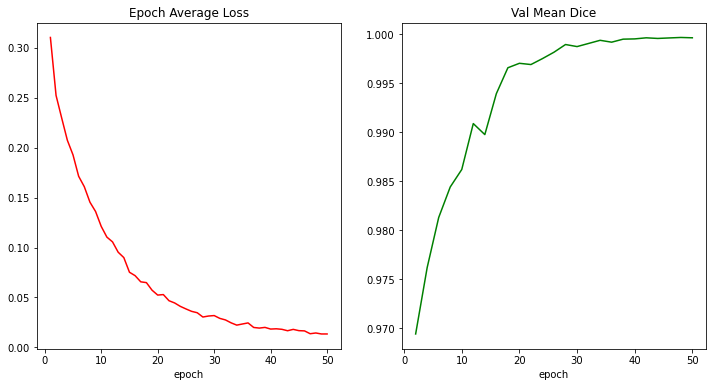

Dice in Test partition for run 80.9998189210891724
Training for run 9
----------
epoch 1/10
1/22, train_loss: 0.4354
2/22, train_loss: 0.4553
3/22, train_loss: 0.4082
4/22, train_loss: 0.4767
5/22, train_loss: 0.4379
6/22, train_loss: 0.4476
7/22, train_loss: 0.4258
8/22, train_loss: 0.4131
9/22, train_loss: 0.4850
10/22, train_loss: 0.4071
11/22, train_loss: 0.4089
12/22, train_loss: 0.4190
13/22, train_loss: 0.4022
14/22, train_loss: 0.4239
15/22, train_loss: 0.4058
16/22, train_loss: 0.3990
17/22, train_loss: 0.4583
18/22, train_loss: 0.4515
19/22, train_loss: 0.4186
20/22, train_loss: 0.3885
21/22, train_loss: 0.3937
22/22, train_loss: 0.4318
23/22, train_loss: 0.4023
epoch 1 average loss: 0.4259
----------
epoch 2/10
1/22, train_loss: 0.4229
2/22, train_loss: 0.3576
3/22, train_loss: 0.3720
4/22, train_loss: 0.3881
5/22, train_loss: 0.4168
6/22, train_loss: 0.3944
7/22, train_loss: 0.3484
8/22, train_loss: 0.4081
9/22, train_loss: 0.3884
10/22, train_loss: 0.3755
11/22, train_loss

saved new best metric model
current epoch: 12 current mean dice: 0.9922 best mean dice: 0.9922 at epoch 12
----------
epoch 13/10
1/22, train_loss: 0.1233
2/22, train_loss: 0.1105
3/22, train_loss: 0.1429
4/22, train_loss: 0.1177
5/22, train_loss: 0.1960
6/22, train_loss: 0.1283
7/22, train_loss: 0.1848
8/22, train_loss: 0.1528
9/22, train_loss: 0.1083
10/22, train_loss: 0.1448
11/22, train_loss: 0.1168
12/22, train_loss: 0.1088
13/22, train_loss: 0.1134
14/22, train_loss: 0.1517
15/22, train_loss: 0.1063
16/22, train_loss: 0.1382
17/22, train_loss: 0.1151
18/22, train_loss: 0.1544
19/22, train_loss: 0.1326
20/22, train_loss: 0.1242
21/22, train_loss: 0.1434
22/22, train_loss: 0.1745
23/22, train_loss: 0.1038
epoch 13 average loss: 0.1345
----------
epoch 14/10
1/22, train_loss: 0.1088
2/22, train_loss: 0.1171
3/22, train_loss: 0.1765
4/22, train_loss: 0.1162
5/22, train_loss: 0.1151
6/22, train_loss: 0.1160
7/22, train_loss: 0.1288
8/22, train_loss: 0.1473
9/22, train_loss: 0.1030
10/

20/22, train_loss: 0.0497
21/22, train_loss: 0.1139
22/22, train_loss: 0.0519
23/22, train_loss: 0.0664
epoch 24 average loss: 0.0600
saved new best metric model
current epoch: 24 current mean dice: 0.9991 best mean dice: 0.9991 at epoch 24
----------
epoch 25/10
1/22, train_loss: 0.0541
2/22, train_loss: 0.0419
3/22, train_loss: 0.0455
4/22, train_loss: 0.0428
5/22, train_loss: 0.0563
6/22, train_loss: 0.0660
7/22, train_loss: 0.1220
8/22, train_loss: 0.0590
9/22, train_loss: 0.0569
10/22, train_loss: 0.0534
11/22, train_loss: 0.0350
12/22, train_loss: 0.0672
13/22, train_loss: 0.0595
14/22, train_loss: 0.1082
15/22, train_loss: 0.0671
16/22, train_loss: 0.0436
17/22, train_loss: 0.0520
18/22, train_loss: 0.0443
19/22, train_loss: 0.0349
20/22, train_loss: 0.0384
21/22, train_loss: 0.1005
22/22, train_loss: 0.0438
23/22, train_loss: 0.0300
epoch 25 average loss: 0.0575
----------
epoch 26/10
1/22, train_loss: 0.0523
2/22, train_loss: 0.0526
3/22, train_loss: 0.0551
4/22, train_loss: 0

19/22, train_loss: 0.0162
20/22, train_loss: 0.0286
21/22, train_loss: 0.0218
22/22, train_loss: 0.0210
23/22, train_loss: 0.0157
epoch 36 average loss: 0.0300
saved new best metric model
current epoch: 36 current mean dice: 0.9997 best mean dice: 0.9997 at epoch 36
----------
epoch 37/10
1/22, train_loss: 0.0211
2/22, train_loss: 0.0341
3/22, train_loss: 0.0417
4/22, train_loss: 0.0220
5/22, train_loss: 0.0460
6/22, train_loss: 0.0268
7/22, train_loss: 0.0324
8/22, train_loss: 0.0391
9/22, train_loss: 0.0537
10/22, train_loss: 0.0159
11/22, train_loss: 0.0236
12/22, train_loss: 0.0276
13/22, train_loss: 0.0378
14/22, train_loss: 0.0206
15/22, train_loss: 0.0333
16/22, train_loss: 0.0221
17/22, train_loss: 0.0263
18/22, train_loss: 0.0230
19/22, train_loss: 0.0198
20/22, train_loss: 0.0252
21/22, train_loss: 0.0233
22/22, train_loss: 0.0225
23/22, train_loss: 0.0230
epoch 37 average loss: 0.0287
----------
epoch 38/10
1/22, train_loss: 0.0388
2/22, train_loss: 0.0226
3/22, train_loss: 

20/22, train_loss: 0.0163
21/22, train_loss: 0.0251
22/22, train_loss: 0.0133
23/22, train_loss: 0.0158
epoch 48 average loss: 0.0186
saved new best metric model
current epoch: 48 current mean dice: 0.9998 best mean dice: 0.9998 at epoch 48
----------
epoch 49/10
1/22, train_loss: 0.0345
2/22, train_loss: 0.0205
3/22, train_loss: 0.0177
4/22, train_loss: 0.0186
5/22, train_loss: 0.0214
6/22, train_loss: 0.0203
7/22, train_loss: 0.0337
8/22, train_loss: 0.0141
9/22, train_loss: 0.0216
10/22, train_loss: 0.0181
11/22, train_loss: 0.0176
12/22, train_loss: 0.0406
13/22, train_loss: 0.0126
14/22, train_loss: 0.0077
15/22, train_loss: 0.0169
16/22, train_loss: 0.0132
17/22, train_loss: 0.0151
18/22, train_loss: 0.0112
19/22, train_loss: 0.0120
20/22, train_loss: 0.0091
21/22, train_loss: 0.0103
22/22, train_loss: 0.0100
23/22, train_loss: 0.0100
epoch 49 average loss: 0.0177
----------
epoch 50/10
1/22, train_loss: 0.0119
2/22, train_loss: 0.0199
3/22, train_loss: 0.0238
4/22, train_loss: 0

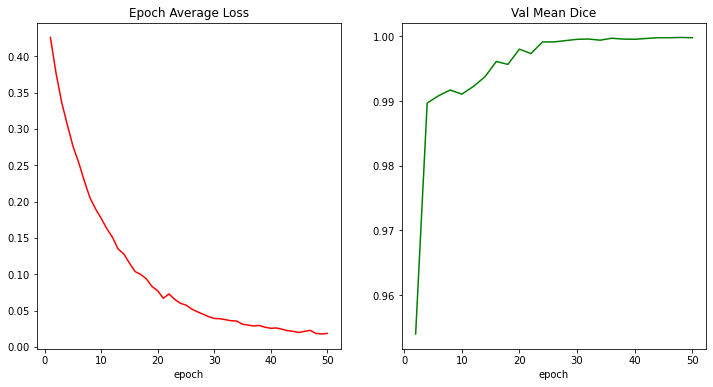

Dice in Test partition for run 90.9998973608016968


In [100]:
best_val_performances = []
test_performances = []
file_performances_test = open( OUTPUT+ 'performances_dice_'+EXPERIMENT.split('/')[0]+'.txt','w')
epocs = 50
runs = 10
for run_num in range(runs):
    print(f"Training for run {run_num}")
    model = monai.networks.nets.UNet(
        spatial_dims=2,
        in_channels=1,
        out_channels=1,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
    ).to(device)

    loss_function = monai.losses.DiceLoss(sigmoid=True)
    optimizer     = torch.optim.Adam(model.parameters(), 1e-3)

    # start a typical PyTorch training
    val_interval = 2
    best_metric  = -1
    best_metric_epoch = -1
    
    epoch_loss_values  = list()
    metric_values      = list()
    metric_values_test = list()
    writer = SummaryWriter()
    
    for epoch in range(epocs):
        
        print("-" * 10)
        print(f"epoch {epoch + 1}/{10}")
        model.train()
        epoch_loss = 0
        step = 0
        
        for batch_data in train_loader:
            step += 1
            inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            epoch_len   = len(train_ds) // train_loader.batch_size
            
            print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
            writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
            
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
        if (epoch + 1) % val_interval == 0:
            model.eval()
            
            with torch.no_grad():
                val_images  = None
                val_labels  = None
                val_outputs = None
                
                for val_data in val_loader:
                    val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                    roi_size = (96, 96)
                    sw_batch_size = 4
                    val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)
                    val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                    # compute metric for current iteration
                    #print("========")
                    #print(val_outputs[0].shape,val_labels[0].shape)
                    dice_metric(y_pred=val_outputs, y=val_labels)
                    #print("========")

                # aggregate the final mean dice result
                metric = dice_metric.aggregate().item()
                # reset the status for next validation round
                dice_metric.reset()
                metric_values.append(metric)
                
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    
                    torch.save(model.state_dict(),ROOT_EXP+"/models/"+EXPERIMENT+"run_" +str(run_num)+"_best_metric_model_segmentation2d_array.pth")
                   
                print("saved new best metric model")
                print(
                    "current epoch: {} current mean dice: {:.4f} best mean dice: {:.4f} at epoch {}".format(
                        epoch + 1, metric, best_metric, best_metric_epoch
                    )
                )
                writer.add_scalar("val_mean_dice", metric, epoch + 1)
                # plot the last model output as GIF image in TensorBoard with the corresponding image and label
                plot_2d_or_3d_image(val_images, epoch + 1, writer, index=0, tag="image")
                plot_2d_or_3d_image(val_labels, epoch + 1, writer, index=0, tag="label")
                plot_2d_or_3d_image(val_outputs, epoch + 1, writer, index=0, tag="output")
    
    best_val_performances.append(best_metric)
    
    plt.figure("train", (12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Epoch Average Loss")
    x = [i + 1 for i in range(len(epoch_loss_values))]
    y = epoch_loss_values
    plt.xlabel("epoch")
    plt.plot(x, y, color="red")
    plt.subplot(1, 2, 2)
    plt.title("Val Mean Dice")
    x = [val_interval * (i + 1) for i in range(len(metric_values))]
    y = metric_values
    plt.xlabel("epoch")
    plt.plot(x, y, color="green")
    plt.savefig(OUTPUT+ f'trainin_dice_run_{run_num}_'+EXPERIMENT.split('/')[0]+'.jpg')
    plt.show()

    
    
    #Evaluation in the test partition
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        roi_size = (96, 96)
        sw_batch_size = 4
        test_outputs = sliding_window_inference(test_images, roi_size, sw_batch_size, model)
        test_outputs = [post_trans(i) for i in decollate_batch(test_outputs)]
        dice_metric_test(y_pred=test_outputs, y=test_labels)
    metric_test = dice_metric_test.aggregate().item()
    
    dice_metric_test.reset()
    test_performances.append(metric_test)
    print("Dice in Test partition for run " + str(run_num) + str(metric_test))
    file_performances_test.write(str(metric_test)+'\n')
    
    
    
    
file_performances_test.close()

In [101]:
metric_values

[0.953996479511261,
 0.9896892309188843,
 0.9908259510993958,
 0.9917038679122925,
 0.9910589456558228,
 0.9922393560409546,
 0.9937246441841125,
 0.996110737323761,
 0.9956599473953247,
 0.9980174899101257,
 0.9973326921463013,
 0.9991334676742554,
 0.9991368055343628,
 0.9993363618850708,
 0.9995366930961609,
 0.9995816946029663,
 0.9994035959243774,
 0.9997049570083618,
 0.9995759129524231,
 0.9995445013046265,
 0.9996663928031921,
 0.999783992767334,
 0.9997831583023071,
 0.9998233914375305,
 0.9997817873954773]

In [102]:
test_performances

[0.999882698059082,
 0.9998468160629272,
 0.9998568296432495,
 0.9998229742050171,
 0.9997369050979614,
 0.999785304069519,
 0.9998327493667603,
 0.9998544454574585,
 0.9998189210891724,
 0.9998973608016968]

In [103]:
best_val_performances

[0.9997949600219727,
 0.9996792078018188,
 0.9996770620346069,
 0.9996930360794067,
 0.9994651675224304,
 0.9995256662368774,
 0.9997345805168152,
 0.9997186660766602,
 0.9996464848518372,
 0.9998233914375305]

In [ ]:
### print(val_outputs[0].shape, val_labels.shape)

In [104]:
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
writer.close()

train completed, best_metric: 0.9998 at epoch: 48


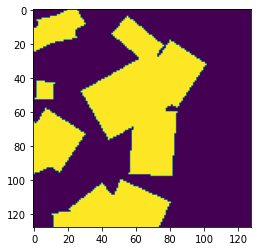

In [105]:
plt.imshow(val_outputs[0][0].cpu().numpy())

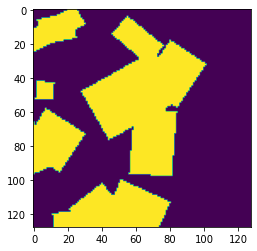

In [106]:
plt.imshow(val_labels[0][0].cpu().numpy())

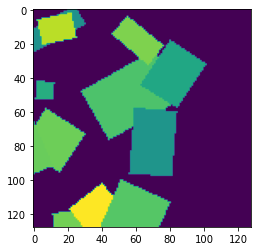

In [107]:
plt.imshow(val_images[0][0].cpu().numpy())